# Homework 3 - Ames Housing Dataset

![profile](https://user-images.githubusercontent.com/8913742/67155424-22613180-f2dd-11e9-98b5-b2c99be7ba16.PNG)

**Importing required libraries**

In [0]:
'''
******************************************************************************
  CSE-519-Data Science Fundamentals HW3
  Name: Rishabh Goel
  SBU Id : 112714848
  Email Id: rishabh.goel@stonybrook.edu
  Kaggle profile link : https://www.kaggle.com/rishabhgoelsbu
*******************************************************************************
'''

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools

from scipy import stats         # calcualting correlation
from scipy.stats import norm
from scipy.stats.stats import pearsonr

import seaborn as sns              # plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm

import datetime                   # for working with dates
import matplotlib.dates as mdates

import csv                        # for saving from and loading to colab
from google.colab import files

from sklearn.model_selection import train_test_split   #data preprocessing 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import pdist  # library for distance function
from sklearn.utils import shuffle

import multiprocessing        # need multiprocessing for fast matrix operations
from joblib import Parallel, delayed
from tqdm import tqdm

import operator     # clustering array preprocessing
from collections import Counter

from sklearn.cluster import DBSCAN     # clustering library
 
from sklearn.datasets.samples_generator import make_blobs 

from sklearn.linear_model import LinearRegression   #modelling libraries
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics       #evaluating metric
from sklearn.metrics import mean_squared_error

import warnings                  #ignore warnings
warnings.filterwarnings('ignore')

**Loading data from google drive to colab**

In [0]:
#Reference : https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
    
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# read csv from google drive
def readcsv(link,filename,col=None):
  fluff, id = link.split('=')
  print (id) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)
  return pd.read_csv(filename,index_col=col)

In [0]:
train_link ='https://drive.google.com/open?id=1oIE5znCp4iJv_S8nVjrV1dlQebiJvkNS'
test_link = 'https://drive.google.com/open?id=1NYv8crPOOFE32nuTM2WsUXJJB0KMsN1C'
sample_submission_link = 'https://drive.google.com/open?id=1y897rOanbS9la4PgL9BbUIn-70fSMUUz'

In [372]:
#train data
train_data = readcsv(train_link,'train.csv')
#test data
test_data = readcsv(test_link,'test.csv')
#sample submission
sample_submission = readcsv(sample_submission_link,'sample_submission.csv','Id')

1oIE5znCp4iJv_S8nVjrV1dlQebiJvkNS
1NYv8crPOOFE32nuTM2WsUXJJB0KMsN1C
1y897rOanbS9la4PgL9BbUIn-70fSMUUz


**Studying data**

In [373]:
# Peeking into train data
print(train_data.shape)

(1460, 81)


## Part 0 - Data Preprocessing

In [0]:
# Finding categorical variables for separate preprocessing
categorical_features=[]
for col in train_data:
  if(train_data[col].nunique()<50):
    categorical_features.append(col)

In [0]:
feat_labels = dict()

# features rated as Ex, Gd, TA, Fa, Po
feature_rated =['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
                'HeatingQC','KitchenQual','FireplaceQu','GarageQual']

train_encoded = train_data.copy()
train_encoded.fillna(train_encoded.mean(),inplace=True)

for feature in train_encoded:
    # label encoding categorical features
    if train_encoded[feature].dtype=='object':
        # manual encoding to maintain original value of these features
        if feature in feature_rated:
          train_encoded[feature] = train_encoded[feature].map({'Ex': 4,
                                                               'Gd': 3, 
                                                               'TA': 2,
                                                               'Fa': 1, 
                                                               'Po': 0}).fillna(-1)
          feat_labels[feature] = {'Ex': 4, 'Gd': 3, 'TA': 2,
                                  'Fa': 1, 'Po': 0, 'N/A' : -1}
        # otherwise use label encoder
        else:
          lbl = preprocessing.LabelEncoder()
          lbl.fit(list(train_encoded[feature].values))
          train_encoded[feature] = lbl.transform(list(train_encoded[feature].values))
          feat_labels[feature] = lbl
train_encoded.fillna(-1,inplace=True)

## Part 1 - Pairwise Correlations

In [0]:
correlations = {}
columns = train_encoded.columns.tolist()

for col in train_encoded:
    correlations[col,'SalePrice'] = pearsonr(train_encoded.loc[:, col],
                                             train_encoded.loc[:, 'SalePrice'])[0]
#correlations in decreasing order
pos_corr = sorted(correlations.items(), key=lambda x: x[1],reverse=True)
#correlations in increasing order
neg_corr = sorted(correlations.items(), key=lambda x: x[1])

**Top 15 Positively correlated features with 'SalePrice'**

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual',
       'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual',
       'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu', 'YearRemodAdd'],
      dtype='object')


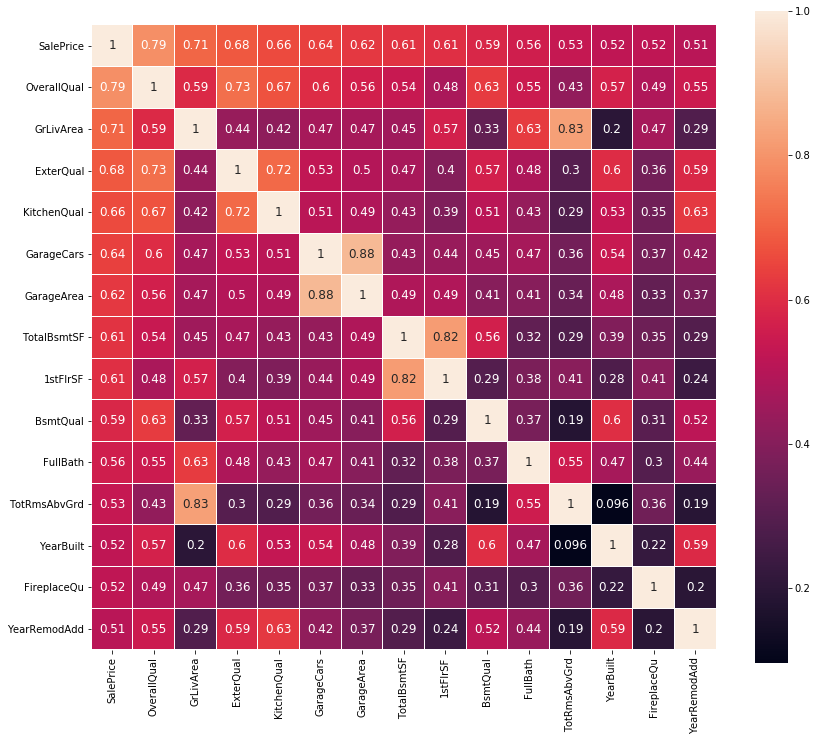

In [377]:
numeric_features = train_encoded.select_dtypes(include=[np.number])
correlation = train_encoded.corr()
k= 15
cols = correlation.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(train_encoded[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, linewidths=0.01,square=True,annot=True,
            linecolor="white",xticklabels = cols.values ,
            annot_kws = {'size':12},yticklabels = cols.values)

**Top 15 Negatively correlated features with 'SalePrice'**

Index(['SalePrice', 'GarageFinish', 'GarageType', 'LotShape', 'MSZoning',
       'KitchenAbvGr', 'EnclosedPorch', 'PoolQC', 'BsmtFinType1', 'Heating',
       'BldgType', 'MSSubClass', 'OverallCond', 'LotConfig', 'SaleType',
       'YrSold'],
      dtype='object')


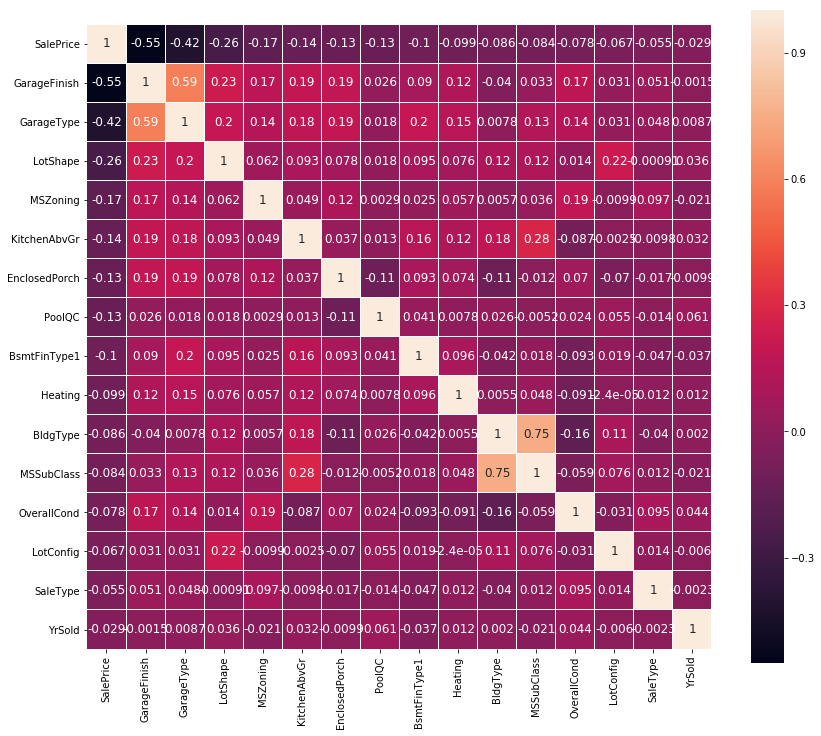

In [378]:
numeric_features = train_encoded.select_dtypes(include=[np.number])
correlation = train_encoded.corr()
k= 15
cols = correlation.nlargest(1,'SalePrice')['SalePrice'].append(
    correlation.nsmallest(k,'SalePrice')['SalePrice'])
cols_index = cols.index
print(cols_index)
cm = np.corrcoef(train_encoded[cols_index].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, linewidths=0.01,square=True,annot=True,
            linecolor="white",xticklabels = cols_index.values ,
            annot_kws = {'size':12},yticklabels = cols_index.values)

## Observations - Part 1



*   **Positive correlation** <br>
'OverallQual', 'GrLivArea', 'GarageCars' and 'TotalBsmtSF' are <br>
strongly correlated with 'SalePrice'.<br>
There are other highly correlated features with 'SalePrice' but they<br>
are already correlated with above 3 features <br>
('OverallQual' with 'ExterQual' & 'KitchenQual', TotRmsAbvGrd' with 'GrLivArea',<br>
GarageCars' with 'GarageArea', '1stFloorSF' with 'TotalBsmtSF'),<br>
so we needn't include them. I am just considering the highest <br>
correlation variables out of the pairs in brackets.


*   **Negative correlation** <br>
The negative correlation is lower in magnitude than the positive correlation.<br>
Also, we need to consider the fact that some of them are randomly label encoded,<br>
so the correlation might not entirely be the correct value. This means that there<br>
are less number of negatively correlated variabes. We can conclude that although <br>
not negatively correlated, there might be some features that have no significant<br>
correlation with 'SalePrice' such as 'MiscFeature', 'LotConfig' and 'SaleType'.



## Part 2 - Informative Plots

## Interesting Plot #1

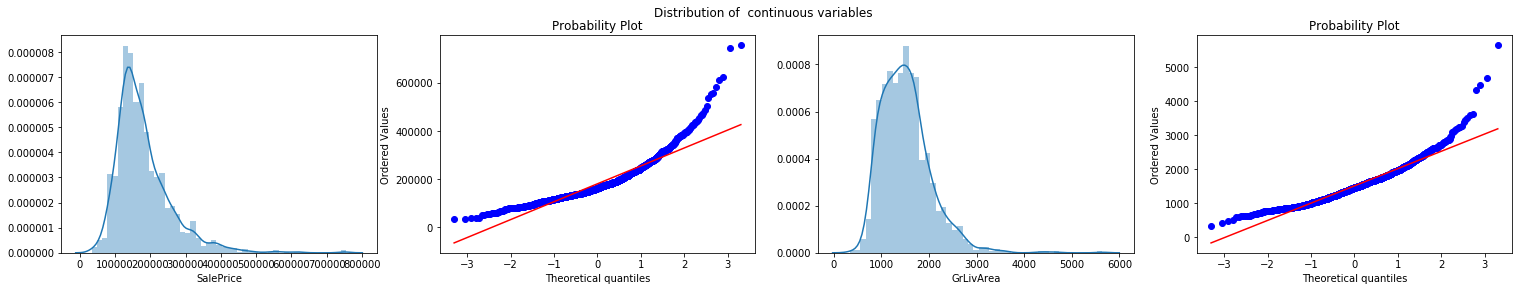

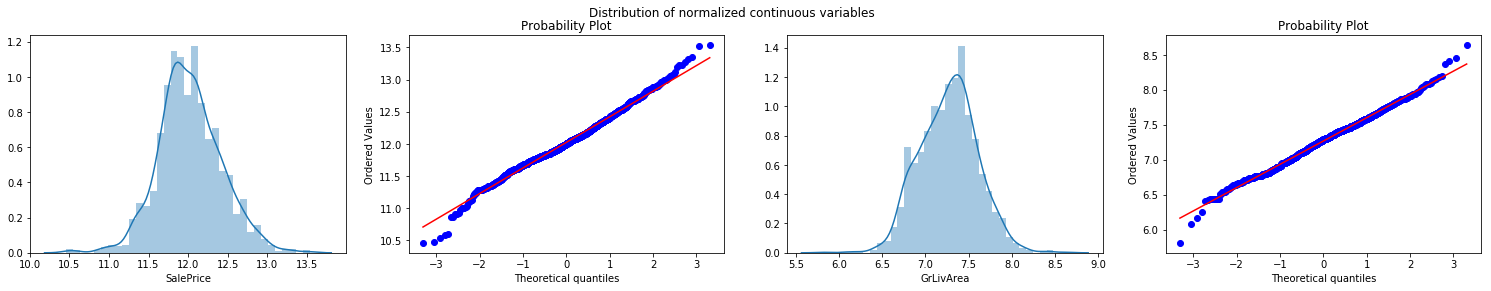

In [379]:
#histogram and normal probability plot
def plot_dist(data,features,label):
  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(26,4))
  for i in range(0,len(features)):
    sns.distplot(data[features[i]],ax=axs[i*2]);
    res = stats.probplot(data[features[i]], plot=axs[i*2+1])
    fig.suptitle("Distribution of " +label+ " continuous variables")
    
train_plot = train_encoded.copy()
train_normal = train_encoded.copy()

continuous_features =['SalePrice','GrLivArea']
plot_dist(train_plot,continuous_features,"")

train_normal['GrLivArea'] = np.log(train_normal['GrLivArea'])
train_normal['SalePrice'] = np.log(train_normal['SalePrice'])
train_normal.loc[train_normal['TotalBsmtSF']>0,'TotalBsmtSF'] = np.log(train_normal['TotalBsmtSF'])
plot_dist(train_normal,continuous_features,"normalized")

del train_plot

## Observations - Plot 1
What interesting properties does Plot 1 reveal? <br>

*   We plot continuous valued variables here, namely 'SalePrice' and 'GrLivArea'. <br>

*   We observe both of these are positively skewed. <br>

*   We transform them into a normal distribution by taking a log of their values.


## Interesting Plot #2

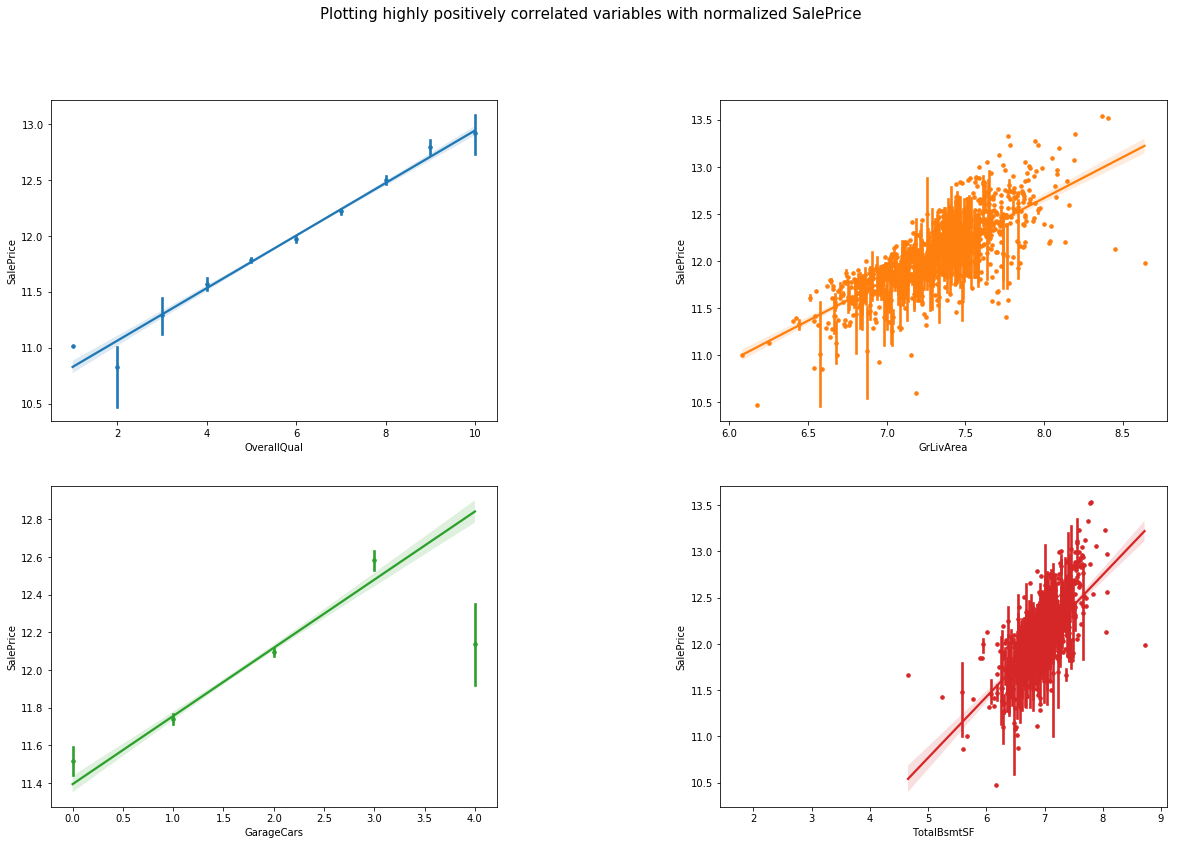

In [380]:
train_scatter = train_normal.copy()
train_scatter = train_scatter.loc[train_scatter['TotalBsmtSF']<3500.0]
train_scatter = train_scatter.loc[train_scatter['TotalBsmtSF']>0.0]

def plot_scatter(features,title):
  fig, (axs,axs1) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
  fig.subplots_adjust(wspace=0.5)
  for i in range(0,len(features)):
    plot = pd.concat([train_scatter['SalePrice'],train_scatter[features[i]]],axis = 1)
    if i<2 :
      g = sns.regplot(x=features[i],y = 'SalePrice',data = plot,scatter= True,
                      truncate=True,x_estimator=np.mean,marker='.',
                      fit_reg=True,ax=axs[i])
    else:
      g = sns.regplot(x=features[i],y = 'SalePrice',data = plot,scatter= True,
                      truncate=True,x_estimator=np.mean,marker='.',
                      fit_reg=True,ax=axs1[i-2])
    fig.suptitle("Plotting highly "+title+"ly correlated variables 
                 with normalized SalePrice",fontsize="15")
    if title=='negative':
      g.set(xticklabels=feat_labels[features[i]])
  
pos_features =['OverallQual','GrLivArea','GarageCars','TotalBsmtSF']
plot_scatter(pos_features,'positive')

del train_scatter

## Observations - Plot 2

What interesting properties does Plot 2 reveal? <br>

We plot 4 highly positively correlated features with SalePrice.


---



*   SalePrice is highly correlated with OverallQual i.e the overall rating of material and finish of the house.
*   It is also natural that SalePrice has high positive correlation with living area and basement area.
*   More the space for GarageCars, more is the SalePrice of the house, we have some instances of houses <br>
having too much space and less SalePrice though.


---



## Interesting Plot #3

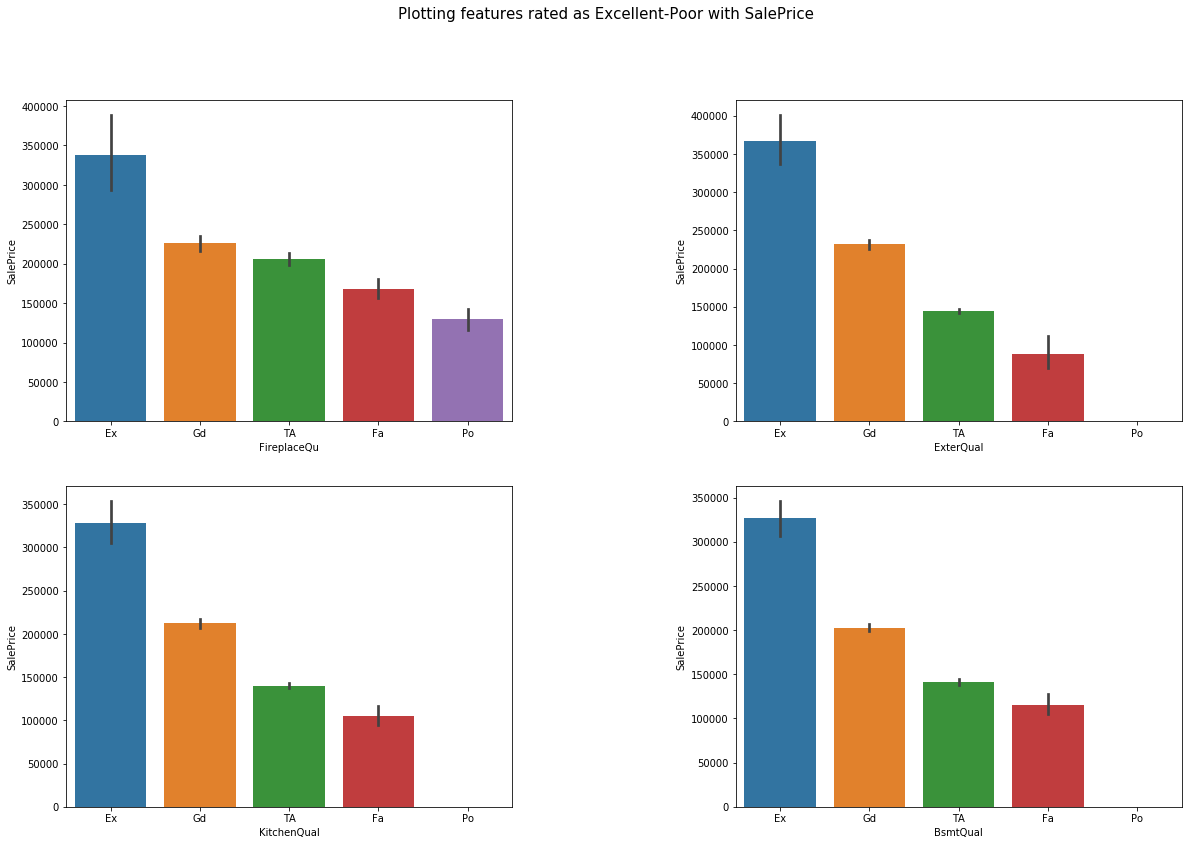

In [381]:

def plot_cat(features):
  fig, (axs,axs1) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
  fig.subplots_adjust(wspace=0.5)
  for i in range(0,len(features)):
    if i<2 :
      sns.catplot(x=features[i], y="SalePrice",
            data=train_data,kind="bar",ax=axs[i],order=['Ex','Gd','TA','Fa','Po'])
    else:
      sns.catplot(x=features[i], y="SalePrice",
            data=train_data,kind="bar",ax=axs1[i-2],order=['Ex','Gd','TA','Fa','Po'])
    fig.suptitle("Plotting features rated as Excellent-Poor with SalePrice",fontsize="15")
    plt.close(2)
house_features = ['FireplaceQu','ExterQual','KitchenQual','BsmtQual']
plot_cat(house_features)


## Observations - Plot 3

What interesting properties does Plot 3 reveal?
We plot features rated as Excellent, Good, Average, Fair and Poor against SalePrice.


*   We observe these ratings do affect SalePrice a lot and end up being deciding<br>
factors on whether the sale price of house will be high or low.

*   Out of the 4 plots, 'FireplaceQu' being of lower quality doesn't punish<br>
SalePrice that much as compared to the other 3 features.



## Interesting Plot #4

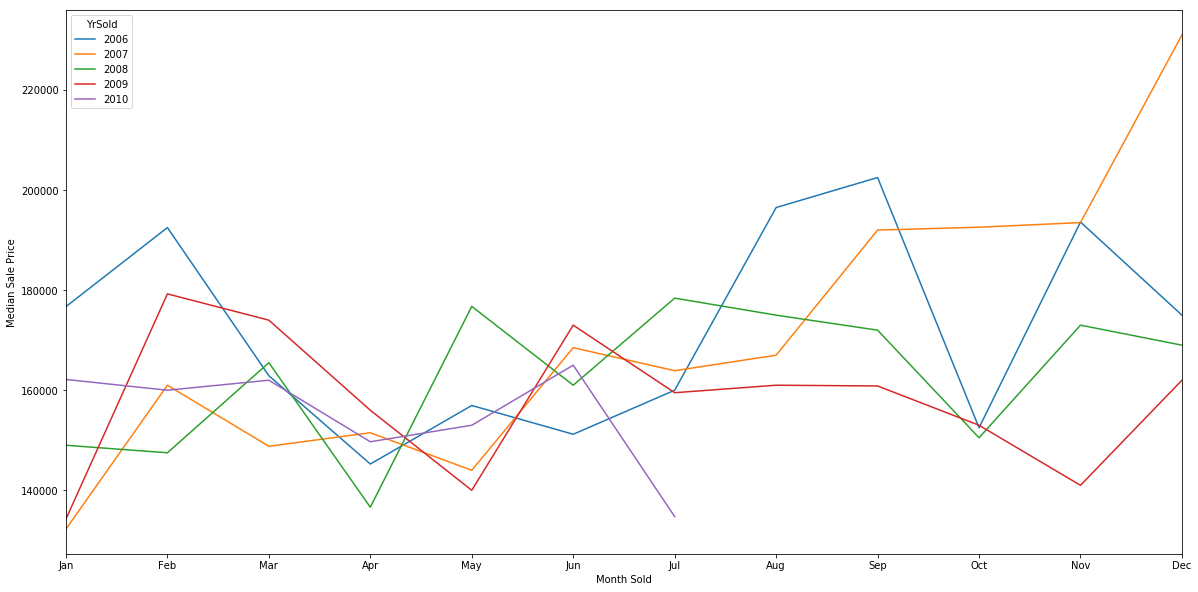

In [382]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig, ax = plt.subplots(figsize=(20,10))
train_data.groupby(['MoSold','YrSold']).median()['SalePrice'].unstack().plot(ax=ax)
plt.xticks(np.arange(1,13),months)
plt.xlabel('Month Sold')
plt.ylabel('Median Sale Price')
plt.show()

## Observations - Plot 4
What interesting properties does Plot 4 reveal?<br>
We plot median SalePrice per month for every year of sale data.<br>
The major observations we could make from the above plot are:


*   For the year 2007, the median SalePrice is increasing as we move from January to December.
*   Prices are generally lower for the years after 2007, recession might be one of the <br>
factors for this trend.
*   Months of April and May seem to be the best months for buying a house as prices <br>
seem to drop around that time each year.
*   On the other hand, prices seem to jump up in the months of August and September every year.




## Interesting Plot #5

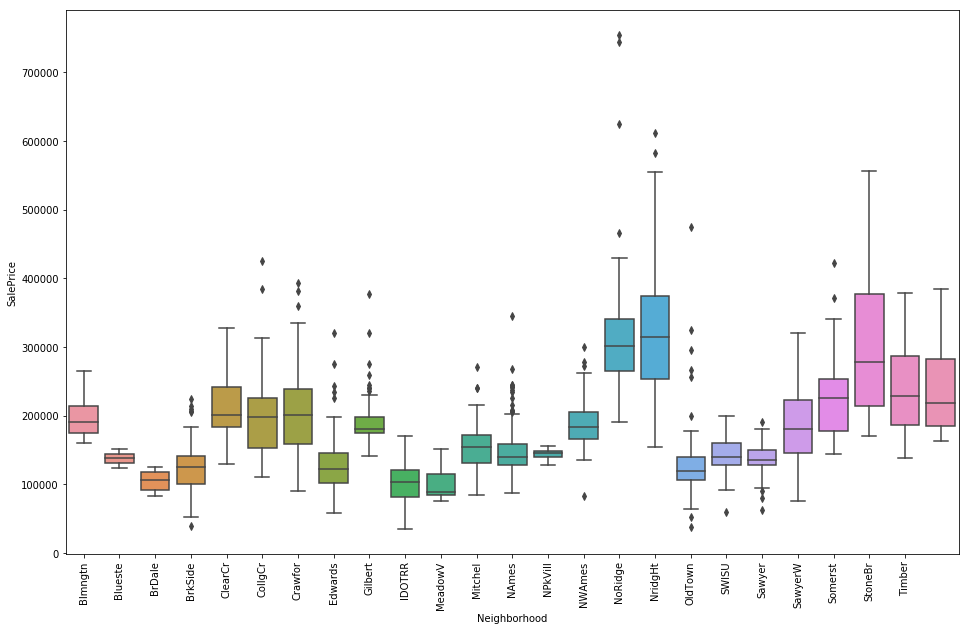

In [383]:
var = 'Neighborhood'
data = pd.concat([train_encoded['SalePrice'], train_encoded[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 10))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
plt.xticks(np.arange(0,24),feat_labels['Neighborhood'].classes_)
xt = plt.xticks(rotation=90)

## Observations - Plot 5

What interesting properties does Plot 5 reveal? <br>
We plot 'SalePrice' against 'Neighborhood' .<br>
From this, we can actually find cheap and expensive neighborhoods.<br>
* Some expensive neighbourhoods are '**NoRidge**', '**NridgHt**' and '**StoneBr**'.
* Some cheap neigbourhoods are '**MeadowV**', '**OldTown**' and '**BrDale**'.

## Part 3 - Handcrafted Scoring Function

In [0]:
def create_new_column(row):
    if row['Neighborhood'] in[15,16,22]:
        return 1
    else:
        return 0

train_scorer = train_encoded.copy()
train_scorer['RichNeighborhood'] = train_scorer.apply(lambda x: create_new_column(x), axis=1)

In [385]:
# function to count number of houses common in predicted and actual desirable list
def similar(pred,act):
  count=0
  for i in pred:
    for j in act:
      if i==j:
        count=count+1
  return count

features =['GrLivArea','OverallQual','RichNeighborhood','GarageArea','BsmtFinSF1']
weights = [    1      ,     1       ,       1          ,      1         ,       1    ]


X = train_scorer[features]
Y = train_scorer['SalePrice']

names = X.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=names)


scores = np.zeros(len(train_scorer))

for i in range(0,len(features)):
  print("\033[1m Adding feature ... " + features[i],'\033[0m')
  scores = scores + weights[i]*scaled_X[features[i]] 
  train_scorer['score'] = scores
  predicted_top = (train_scorer.sort_values(by='score',ascending=False)[:10]['Id'])
  print("Predicted as most desirable\t\t\t" ,predicted_top.index)
  actual_top = (train_scorer.sort_values(by='SalePrice',ascending=False)[:10]['Id'])
  print("Actually most desirable (acc to SalePrice)      " , actual_top.index)
  print("Number of predictions common to actual\t\t\t" , similar(predicted_top,actual_top))
  predicted_bottom = (train_scorer.sort_values(by='score')[:10]['Id'])
  print("Predicted as least desirable\t\t\t" ,predicted_bottom.index)
  actual_bottom = (train_scorer.sort_values(by='SalePrice')[:10]['Id'])
  print("Actually least desirable (acc to SalePrice)     " , actual_bottom.index)
  print("Number of predictions common to actual\t\t\t" ,similar(predicted_bottom,actual_bottom))
  print("\n")
  
features.append('SalePrice')
features.append('score')
train_scorer = train_scorer[features]

 Adding feature ... GrLivArea 
Predicted as most desirable			 Int64Index([1298, 523, 1182, 691, 1169, 185, 304, 1268, 635, 769], dtype='int64')
Actually most desirable (acc to SalePrice)       Int64Index([691, 1182, 1169, 898, 803, 1046, 440, 769, 178, 798], dtype='int64')
Number of predictions common to actual			 4
Predicted as least desirable			 Int64Index([533, 1100, 916, 29, 528, 696, 489, 434, 1449, 614], dtype='int64')
Actually least desirable (acc to SalePrice)      Int64Index([495, 916, 968, 533, 30, 710, 1337, 705, 1325, 812], dtype='int64')
Number of predictions common to actual			 2


 Adding feature ... OverallQual 
Predicted as most desirable			 Int64Index([1298, 523, 1182, 691, 1169, 185, 58, 583, 798, 1268], dtype='int64')
Actually most desirable (acc to SalePrice)       Int64Index([691, 1182, 1169, 898, 803, 1046, 440, 769, 178, 798], dtype='int64')
Number of predictions common to actual			 4
Predicted as least desirable			 Int64Index([533, 1100, 916, 375, 636, 1321, 71

What is the ten most desirable houses? <br>
According to my scoring function, following are the most desirable houses

In [386]:
train_scorer_top = train_scorer.sort_values(by='score',ascending=False)[:10]
train_scorer_top

,GrLivArea,OverallQual,RichNeighborhood,GarageArea,BsmtFinSF1,SalePrice,score
1298,5642,10,0,1418,5644,160000,26.174764
1182,4476,10,1,813,2096,745000,16.707013
691,4316,10,1,832,1455,755000,15.085441
523,4676,10,0,884,2260,184750,14.415356
1169,3627,10,1,807,1387,625000,13.507700
825,2084,10,1,1220,1636,385000,13.048785
178,2234,9,1,1166,1904,501837,12.946161
898,2364,9,1,820,2188,611657,12.197673
769,3279,8,1,841,1416,538000,11.621273
440,2402,10,1,672,1767,555000,11.377507


What is the ten least desirable houses? <br>
According to my scoring function, following are the least desirable houses

In [387]:
train_scorer_bottom = train_scorer.sort_values(by='score')[:10]
train_scorer_bottom

,GrLivArea,OverallQual,RichNeighborhood,GarageArea,BsmtFinSF1,SalePrice,score
533,334,1,0,0,0,39300,-9.453029
636,800,2,0,0,0,60000,-7.842602
375,904,1,0,0,350,61000,-7.600294
710,729,3,0,0,0,52000,-7.254448
620,864,3,0,0,41,67000,-6.907528
916,480,2,0,308,50,35311,-6.901055
968,968,3,0,0,0,37900,-6.799470
1100,438,2,0,246,290,60000,-6.744710
1337,693,4,0,0,0,52500,-6.599665
649,630,4,0,0,131,84500,-6.432279


## Observations - Part 3

Describe your scoring function and how well you think it worked.<br>
For the handscoring function, I have followed the following steps:


1.   Using the important features from part 1 ('GrLivArea','OverallQual',<br>
'GarageArea','BsmtFinSF1') , I scaled them and added them to a score value<br>
and compared the top 10 predicted and actual houses.

2.   I eliminated features using the similar function which tells <br>
how many houses are same in my top 10 and actual top 10.

3. I have also created a new feature : 
*   RichNeighborhood , which I got from a plot in Part 2 
4. I ran my function for different combination of features and finalized with the <br>
above ones, for which my similar function value is largest for top and bottom houses.

It works quite well as 7 of my top 10 predictions are also there in actual top 10<br>
and 5 of my bottom 10 are there in actual bottom 10.




## Part 4 - Pairwise Distance Function

In [0]:
#normalizing remaining continuous features now
train_dist = train_normal.copy()
for col in train_dist:
  if(train_data[col].nunique()>50 and col not in continuous_features):
    continuous_features.append(col)
    train_dist.loc[train_dist[col]>0,col] = np.log(train_dist[col])
train_dist = train_dist.drop(columns=['Id'])

**Utilizing features used in scoring function but not using RichNeighborhood<br>
since we need to use this later to create neighbor boundaries in clustering**

In [0]:
score_features =['GrLivArea','OverallQual','GarageArea','BsmtFinSF1']

# Adding some important categorical features obtained from plots in part 2
new_features = ['FireplaceQu','KitchenQual','BsmtQual','ExterQual']

# Combining features
features  =  score_features  +  new_features

train_dist['RichNeighborhood'] = train_dist.apply(lambda x: create_new_column(x), axis=1)

train_dist = train_dist[features]

In [390]:
# pairwise distance function on two randomly selected houses
def pDist(i,j):
  return pdist(train_dist.loc[[i, j]])

print('Distance between House 523 and house 1169 : ',pDist(1169,523))

Distance between House 523 and house 1169 :  [1.81967046]


In [0]:
# read matrix from google drive
def readmatrix(link,filename):
  fluff, id = link.split('=')
  print (id) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)
  return np.loadtxt(filename, dtype=float)

# save matrix from colab
def storeResults(res,filename):
  np.savetxt(filename, res, fmt='%f')
  files.download(filename)

*Calculating distance matrix for all pair of houses<br>
It will result in a (1460,1460) matrix*

In [0]:
# run this only once and store matrix and load later for use
# commenting it out , as I have run it once already

#out = np.zeros((train_dist.shape[0],train_dist.shape[0]))
#myList=[i for i in range(0,int(len(train_dist)))]
#x=[i for i in range(0,int(len(train_dist)))]

#num_cores = multiprocessing.cpu_count()
#inputs = tqdm(myList)

#for item in x:
#  out[item]=Parallel(n_jobs=2)(delayed(pDist)(i,item) for i in x)

#storeResults(out,'dist_mat.txt')

In [393]:
out = readmatrix("https://drive.google.com/open?id=1JfU31h7mWcDn6RQR4FJ4X8u2QFYGNbTv",'dist_mat.txt')
out_temp = readmatrix("https://drive.google.com/open?id=1JfU31h7mWcDn6RQR4FJ4X8u2QFYGNbTv",'dist_mat.txt')

1JfU31h7mWcDn6RQR4FJ4X8u2QFYGNbTv
1JfU31h7mWcDn6RQR4FJ4X8u2QFYGNbTv


In [0]:
#discarding self pairs of houses
out_temp[out_temp==0] = np.inf
# there are 1460*1460 values in the matrix as total, so run this loop any 
# number of times between (0,1460*1460) to find a low, medium or high distance pair
for i in range(0,5):
  #print("#",i+1)
  ind = np.unravel_index(np.argmin(out_temp, axis=None), out_temp.shape)
  #print("Distance metric value on selected features", np.min(out_temp))
  #print(ind)
  #print("Distance metric value on all features",pdist(train_normal.loc[[ind[0],ind[1]]]) )
  out_temp[ind] = np.inf

In [0]:
train_1 = train_normal.copy()
X = train_1
names = train_1.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=names)

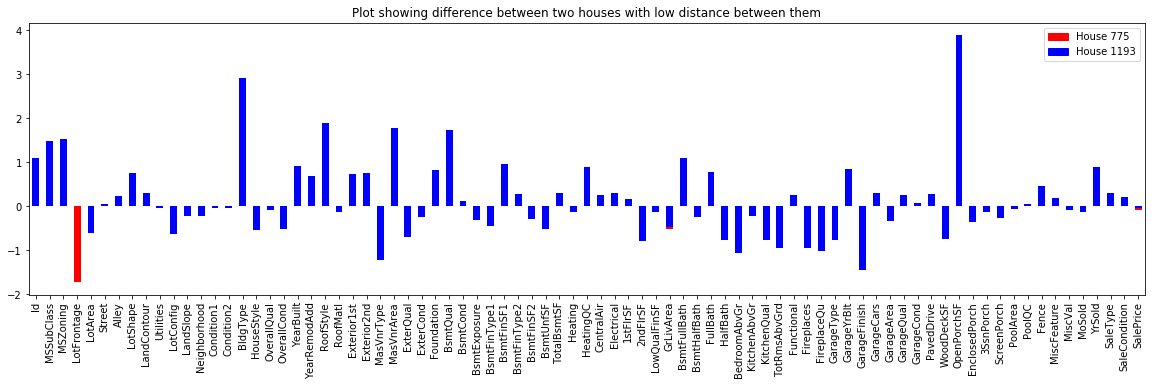

 Distance metric value : 0.860046


In [396]:
row = scaled_X.loc[775]
row1 = scaled_X.loc[1193]
row.plot(kind='bar',figsize=(20,5),color='r')
row1.plot(kind='bar',figsize=(20,5),color='b')
plt.title('Plot showing difference between two houses with low distance between them')
red_patch = mpatches.Patch(color='red', label='House 775')
blue_patch = mpatches.Patch(color='blue', label='House 1193')
plt.legend(handles=[red_patch, blue_patch])
plt.show()
print("\033[1m Distance metric value :", out[775,1193])

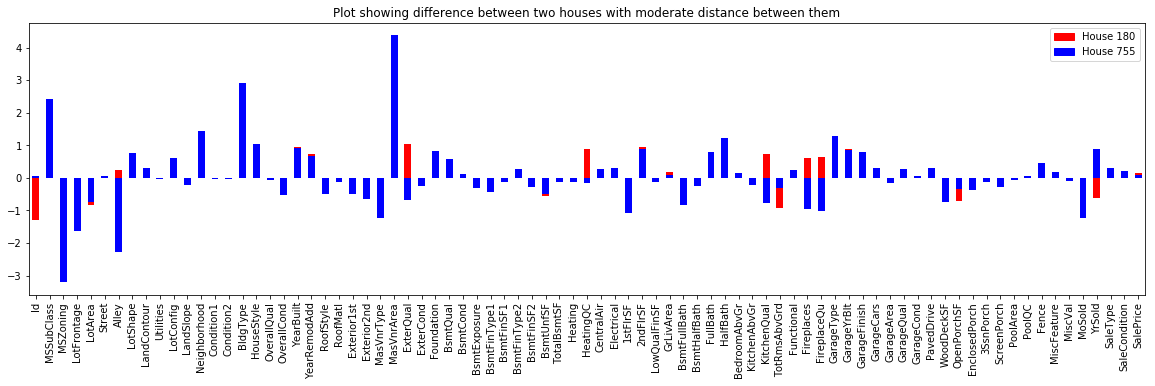

 Distance metric value : 5.940147


In [397]:
row = scaled_X.loc[180]
row1 = scaled_X.loc[755]
row.plot(kind='bar',figsize=(20,5),color='r')
row1.plot(kind='bar',figsize=(20,5),color='b')
plt.title('Plot showing difference between two houses with moderate distance between them')
red_patch = mpatches.Patch(color='red', label='House 180')
blue_patch = mpatches.Patch(color='blue', label='House 755')
plt.legend(handles=[red_patch, blue_patch])
plt.show()
print("\033[1m Distance metric value :", out[180,755])

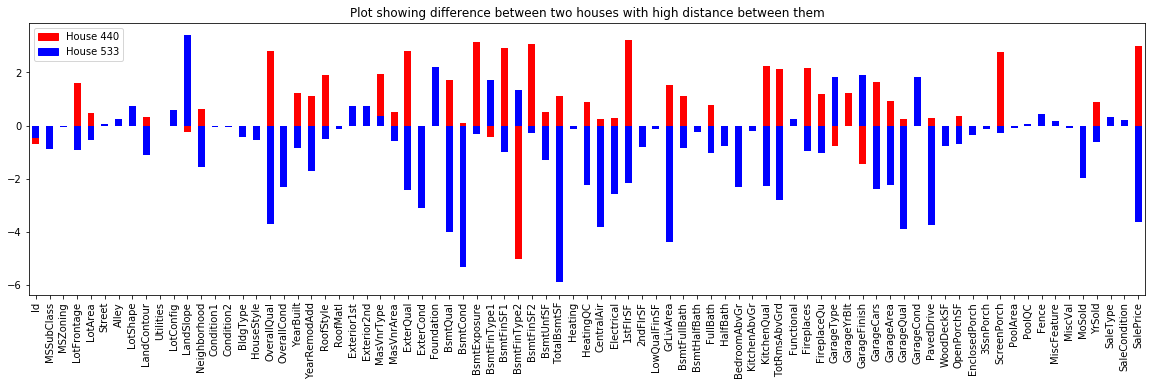

 Distance metric value : 28.987679


In [398]:
row = scaled_X.loc[440]
row1 = scaled_X.loc[533]
row.plot(kind='bar',figsize=(20,5),color='r')
row1.plot(kind='bar',figsize=(20,5),color='b')
plt.title('Plot showing difference between two houses with high distance between them')
red_patch = mpatches.Patch(color='red', label='House 440')
blue_patch = mpatches.Patch(color='blue', label='House 533')
plt.legend(handles=[red_patch, blue_patch])
plt.show()
print("\033[1m Distance metric value :", out[440,533])

## Observations - Part 4
How well does the distance function work? When does it do well/badly?

For the pairwise distance function, I have followed the following steps:


1.   Using the features from my scoring function (part 3) and adding some<br>
useful categorical features obtained in part 2 , I am finding euclidean distance<br>
between every pair of houses and storing them into a (1460,1460) matrix.
2.  To find how well my distance function works, I iterate through my distance matrix<br>
in a sorted way, extracted house pairs having low, medium and high distances. 
3. I scale all the features , so I can plot the difference between house pairs <br>
obtained in step 2 on all features.

It works quite well as we can visualize as the distance increases, we can see <br>
more difference in the values for all columns between house pairs.



## Part 5 - Clustering

In [448]:
db = DBSCAN(eps=0.25, min_samples=7).fit(train_dist)
print('Estimated number of clusters: %d' % (len(set(db.labels_))-1))

cl_data = train_dist.copy()
from sklearn.manifold import TSNE
cl_data_embedded = TSNE(n_components=2, perplexity=50).fit_transform(cl_data)

Estimated number of clusters: 14


In [0]:
cl_data['x'] = cl_data_embedded[:,0]
cl_data['y'] = cl_data_embedded[:,1]
cl_data['label'] = db.labels_
cl_data.label.unique()
groups = cl_data.groupby('label')
no_labels = len(cl_data.label.unique())

neigbor_dict = dict()
for i in range(no_labels):
  neigbor_dict[i-1]=[]
for i in range(len(cl_data)):
  neigbor_dict[cl_data.loc[i]['label']].append(train_encoded.iloc[i]['Neighborhood'])        


In [450]:
nbr_data=dict()
nbr_cols = ['ClusterLabelId', 'Neighbor1','Neighbor1%','Neighbor2','Neighbor2%']
for col in nbr_cols:
  nbr_data[col]=[]

for i in range(no_labels):
  nbr_data['ClusterLabelId'].append(i-1)
  sorted_x = sorted(Counter(neigbor_dict[i-1]).items(), key=operator.itemgetter(1),reverse=True)
  nbr1_p = 100*sorted_x[0][1]/sum(Counter(neigbor_dict[i-1]).values())
  if(len(sorted_x)>1):
    nbr2_p = 100*sorted_x[1][1]/sum(Counter(neigbor_dict[i-1]).values())
  else:
    nbr2_p=0
  nbr_data['Neighbor1%'].append(nbr1_p)
  nbr_data['Neighbor2%'].append(nbr2_p)
  nbr_data['Neighbor1'].append(feat_labels['Neighborhood'].classes_[int(sorted_x[0][0])])
  if(len(sorted_x)>1):
    nbr_data['Neighbor2'].append(feat_labels['Neighborhood'].classes_[int(sorted_x[1][0])])
  else:
    nbr_data['Neighbor2'].append('na')
neigbor_df = pd.DataFrame(nbr_data, columns = nbr_cols)
neigbor_df[1:]

,ClusterLabelId,Neighbor1,Neighbor1%,Neighbor2,Neighbor2%
1,0,CollgCr,68.965517,Somerst,17.241379
2,1,NAmes,46.666667,Sawyer,18.666667
3,2,Somerst,42.857143,NridgHt,21.428571
4,3,Somerst,40.000000,CollgCr,36.666667
5,4,NWAmes,58.333333,Gilbert,33.333333
6,5,NAmes,80.000000,Edwards,10.000000
7,6,Gilbert,73.333333,NWAmes,20.000000
8,7,Gilbert,37.500000,CollgCr,25.000000
9,8,BrDale,77.777778,NAmes,11.111111
10,9,NoRidge,36.363636,Somerst,18.181818


This table represents the percentage of two most prevalent <br>
neighbourhoods in the respective cluster

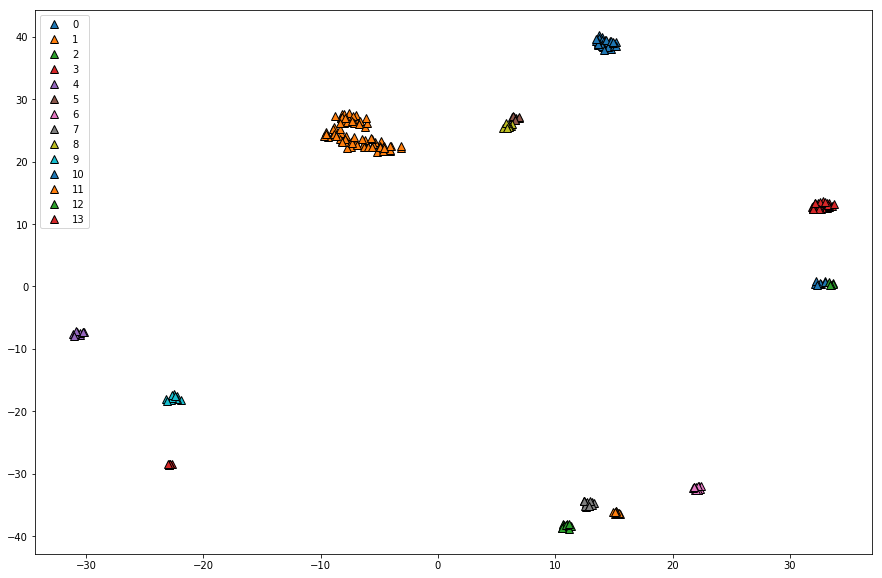

In [451]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
colors = ['yellow', 'blue', 'green', 'red','aqua','lime','gold'] 
ax.margins(0.05)
ax.grid(False)
for name, group in groups:
    lats = group.x
    lons = group.y
    if name == -1:
          # Filtering out the Noise (aka points that couldn't be clustered)
        continue
    else:
        ax.plot(lats, lons,markeredgecolor='k', marker='^', ms=8, linestyle='', label=name)
    
ax.legend()

## Observations - Part 5

How well do the clusters reflect neighborhood boundaries? <br>
Write a discussion on what your clusters capture and how well they work.<br>

I have used DBSCAN clustering with following parameters:
1. *eps* (The maximum distance between two samples for one to be considered<br>
as in the neighborhood of the other) = 0.25
2. *min_samples* (The number of samples (or total weight) in a neighborhood<br>
for a point to be considered as a core point) = 7 <br>

* I got 14 clusters. I observed that each cluster either contains a <br>
major neighborhood or 2 major neighborhoods, which is around 80% of the<br>
cluster neighborhoods. This is a very good result since I haven't<br>
even used the 'Neighborhood' or the custom 'RichNeighborhood' feature.<br>

* There are some neighborhoods like NAmes, CollgCr, Gilbert which appear in more<br>
than 1 clusters.This can be explained by the fact that their frequency in the <br>
original dataset is much more than other neighborhoods.


## Part 6 - Linear Regression

In [0]:
def linear_reg(x,y):
  xTrain, xTest, yTrain, yTest = train_test_split(x,y, test_size = 0.4, random_state = 1)
  reg = LinearRegression().fit(xTrain, yTrain)
  yPred = reg.predict(xTest)
  return mean_squared_error(yTest, yPred)  


In [406]:

imp_features =['Id','GrLivArea','OverallQual','GarageCars','BsmtFinSF1','YearBuilt']
train_regress = train_normal.copy()
y = train_regress['SalePrice']
x = train_regress[imp_features]
linear_reg(x,y)

0.03405689804697316

## Observations - Part 6


How well/badly does it work? Which are the most important variables? <br>
* OverallQual , alone gives mean absolute error of 0.178 , mean squared error 0.058<br>
* 5 most imp features selected/created by me gives mean absolute error of 0.1209, mean squared error 0.034 <br>
* All 80 features used gives mean absolute error of 0.0982, mean squared error 0.025

## Part 7 - External Dataset

In [407]:
# Importing external dataset
ext_data = readcsv('https://drive.google.com/open?id=1Ll79u9YNRKZIcinQKa8Q-68DVBX23eqV','external_dataset.csv')
ext_data = ext_data.rename(columns={"Year": "YrSold"})
ext_data

1Ll79u9YNRKZIcinQKa8Q-68DVBX23eqV


,YrSold,Industrial_return,Industrial_price,Retail_return,Retail_price,Residential_return,Residential_price,HealthCare_return,HealthCare_price,Mortgage_return,Mortgage_price
0,2006,28.92,24.46,29.02,24.00,38.93,33.80,44.55,35.81,19.32,8.43
1,2007,0.38,-3.17,-15.77,-18.97,-25.21,-28.08,2.13,-3.47,-42.35,-47.69
2,2008,-67.47,-69.38,-48.36,-51.28,-24.89,-29.08,-11.98,-17.06,-31.31,-40.46
3,2009,12.17,4.84,27.17,21.57,30.82,22.81,24.62,15.76,24.63,8.26
4,2010,18.89,13.60,33.41,28.43,46.01,40.87,19.20,12.71,22.60,7.01


In [0]:
# Merging with original dataset using YrSold as joining column
train_merge = train_normal.copy()
train_merge = pd.merge(train_merge, ext_data, on='YrSold')

In [409]:
y = train_normal['SalePrice']
x = train_normal.drop(columns=['SalePrice'])
print(" RMSE on log(SalePrice) for original dataset \033[1m" ,linear_reg(x,y))

 RMSE on log(SalePrice) for original dataset  0.026815536268492233


In [410]:
y = train_merge['SalePrice']
x = train_merge.drop(columns=['SalePrice'])
print(" RMSE on log(SalePrice) for modified dataset \033[1m" ,linear_reg(x,y))

 RMSE on log(SalePrice) for modified dataset  0.020740144055266967


## Observations - Part 7

Describe the dataset and whether this data helps with prediction.<br>
External dataset has been taken from the following resources: <br>

*   https://www.usinflationcalculator.com/inflation/current-inflation-rates/ <br>
US inflation rates for the years 2006-2010, this could be joined using YrSold as the joining column.

*   https://www.reit.com/sites/default/files/returns/AnnualSectorReturns.xls <br>
Annual Price and Total Returns by different sectors such as
1.   Industrial
2.   Retail
3.   Residential
4.   HealthCare
5.   Mortgage <br>
This data is again for years 2006-2010, and hence can be joined using YrSold as the joining column.<br>

**Results**
As we can see, rmse value for modified dataset increases by ~ 0.006 as compared <br>
to the original dataset, which is a good result. This shows inflation rate and<br>
prices/returns in Industrial,Residential etc sectors have some impact on the saleprice of houses.


## Part 8 - Permutation Test

In [0]:
def pTest(x,y,no):
  mse_p=[]
  for i in range(0,no):
    y_p = shuffle(y)
    mse_p.append(linear_reg(x,y_p))
  return mse_p

def runpTest(ptest_feat):
  fig, (axs,axs1) = plt.subplots(nrows=2, ncols=5, figsize=(26,8))    

  for i,feat in enumerate(ptest_feat):
    x = train_ptest[['Id',feat]]
    mse_o[feat] = linear_reg(x,y)
    mse_p[feat] = pTest(x,y,100)
    pvalue[feat] = sum(i<=mse_o[feat] for i in mse_p[feat])/100
    if(i<5):
      axx = axs[i]
    elif(i<10):
      axx = axs1[i-5] 
    axx.hist(mse_p[feat],bins=25,label='Permutation scores',edgecolor='black')
    axx.axvline(x=mse_o[feat], color='r', linestyle='dashed', linewidth=2,
            label='Classification Score (pvalue %s)' % pvalue[feat])
    axx.legend()
    axx.set_xlabel(feat)
  
  fig.suptitle("Ptest for some significant and some not so significant features based on rmse of log(price)")
  plt.show()

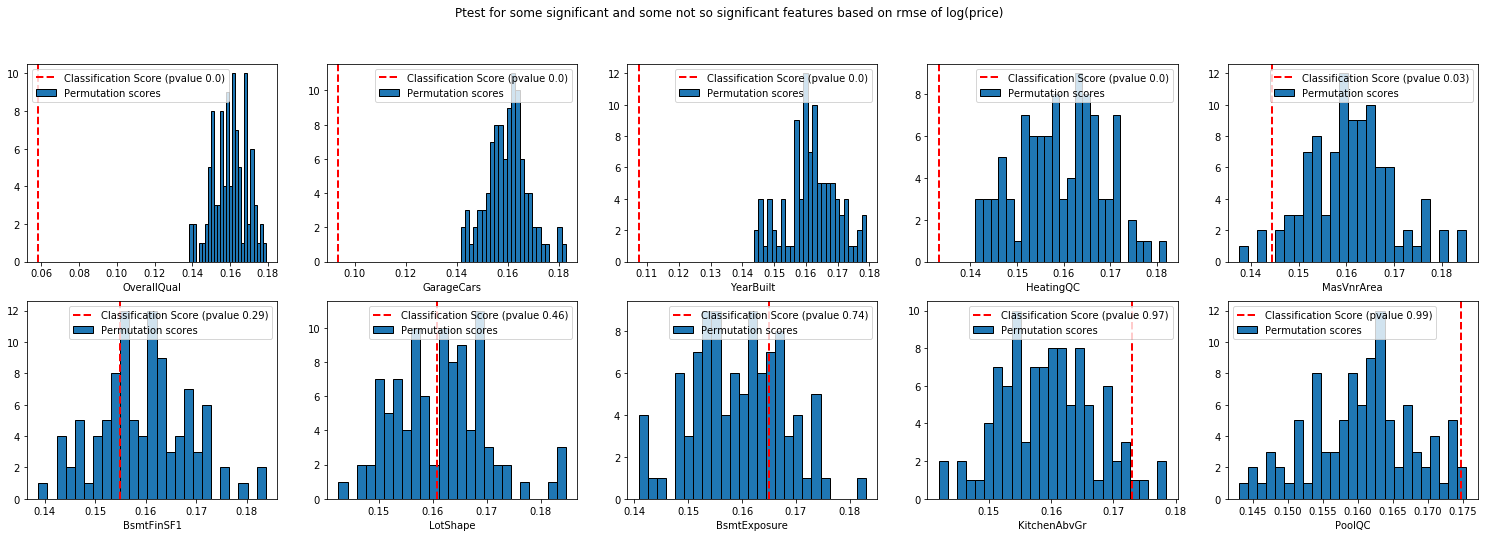

In [412]:
train_ptest = train_normal.copy()
y = train_ptest['SalePrice']

#significant features
ptest_feat_top    = ['OverallQual','GarageCars','YearBuilt','HeatingQC','MasVnrArea']

# not so significant features
ptest_feat_bottom = ['BsmtFinSF1','LotShape', 'BsmtExposure','KitchenAbvGr','PoolQC' ]

ptest_feat = ptest_feat_top + ptest_feat_bottom
mse_p = dict()
mse_o = dict()
pvalue = dict()
runpTest(ptest_feat)

In [413]:
mse_p_avg = dict()
mse_p_min = dict()
mse_p_max = dict()
for key in mse_p:
  mse_p_avg[key] = sum(mse_p[key])/len(mse_p[key])
  mse_p_min[key] = min(mse_p[key])
  mse_p_max[key] = max(mse_p[key])
mse_o_pd = pd.DataFrame.from_dict(mse_o,orient='index',columns=['MSE model'])
pvalue_pd = pd.DataFrame.from_dict(pvalue,orient='index',columns=['P-value'])
mse_p_min_pd = pd.DataFrame.from_dict((mse_p_min),orient='index',
                                      columns=['MSE permutations(min)'])
mse_p_max_pd = pd.DataFrame.from_dict((mse_p_max),orient='index',
                                      columns=['MSE permutations(max)'])
mse_p_avg_pd = pd.DataFrame.from_dict((mse_p_avg),orient='index',
                                      columns=['MSE permutations(avg)'])
pd.concat([mse_o_pd,mse_p_min_pd,mse_p_max_pd,mse_p_avg_pd,pvalue_pd],axis=1)

,MSE model,MSE permutations(min),MSE permutations(max),MSE permutations(avg),P-value
OverallQual,0.058360,0.138495,0.178921,0.159947,0.00
GarageCars,0.093561,0.141426,0.182737,0.159648,0.00
YearBuilt,0.107394,0.143572,0.178918,0.161542,0.00
HeatingQC,0.133199,0.141073,0.182064,0.159254,0.00
MasVnrArea,0.144348,0.137525,0.185147,0.161046,0.03
BsmtFinSF1,0.154903,0.138717,0.183803,0.159550,0.29
LotShape,0.160770,0.142597,0.184652,0.161380,0.46
BsmtExposure,0.165045,0.140782,0.183044,0.159220,0.74
KitchenAbvGr,0.173039,0.141963,0.178488,0.159490,0.97
PoolQC,0.174714,0.143024,0.175512,0.160611,0.99


## Observations - Part 8

Here, we have made plots and a table for 10 variables (5 of which have<br>
been found significant and 5 not so significant)<br>

We observe the following points:


*   Significant variables outperform 100 permutations most of the time.<br>
The reason behind this is there can be a lot of random permutations for our<br>
data and we are just considering a very small fraction of them. Normally, we get<br>
a p-value greater than 0 because in those p-tests, the random permutations <br>
are somewhat representative of the original data.
*   For non -significant variables, however, we get p-values ranging from 0.2-0.99,<br>
as significance of those variables decreases. This is an expected observation,<br>
since a variable which is not correlated much with the SalePrice, will tend to give <br>
unexpected results for different permutations.



## Part 9 - Final Result

In [0]:
def rmsle_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=5).get_n_splits(x)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
  
train_fit = train_encoded.copy()
for col in train_encoded:
  if(train_fit[col].nunique()>50 and col in continuous_features and col!='Id'):
    train_fit.loc[train_fit[col]>0,col] = np.log(train_fit[col])

x = train_fit.drop(columns=['SalePrice'])
y = train_fit['SalePrice']

In [0]:
# Models reference : https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [0]:
#function to train different models based on model Index 
# 0 : Lasso
# 1 : XGBoost
# 2 : LGBM
# 3 : Avergae of base models

def trainModel(modelIndex,regressors):
  if(modelIndex) ==0:
    model = make_pipeline(RobustScaler(), Lasso(alpha =0.0015))
  
  elif modelIndex == 1:
    model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
  elif modelIndex == 2:
      model = lgb.LGBMRegressor(objective='regression',num_leaves=10,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
  elif modelIndex == 3:
    model = AveragingModels(models = (model_xgb, model_lgb, lasso))

  else:
    return
  
  # evaulating model
  score = rmsle_cv(model)
  print(regressors[i],"mean rmse score: {:.5f} \n".format(score.mean()))

In [417]:
regressors = ['Lasso','Xgboost','LGBM','Average of base models']
for i in range(0,len(regressors)):
  trainModel(i,regressors)

Lasso mean rmse score: 0.13431 

Xgboost mean rmse score: 0.12352 

LGBM mean rmse score: 0.12502 

Average of base models mean rmse score: 0.12194 



In [0]:
#preprocessing test data
test_encoded = test_data.copy()
test_encoded.fillna(test_encoded.mean(),inplace=True)
for feature in test_encoded:
    if test_encoded[feature].dtype=='object':
        if feature in feature_rated:
          test_encoded[feature]=test_encoded[feature].map({'Ex': 4, 
                                                           'Gd': 3, 
                                                           'TA': 2, 
                                                           'Fa': 1,
                                                           'Po': 0})
        else:
          lbl = preprocessing.LabelEncoder()
          lbl.fit(list(test_encoded[feature].values))
          test_encoded[feature] = lbl.transform(list(test_encoded[feature].values))

for col in test_encoded:
  if(test_encoded[col].nunique()>50 and col in continuous_features and col!='Id'):
    test_encoded.loc[test_encoded[col]>0,col] = np.log(test_encoded[col])
test_encoded.fillna(-1,inplace=True)

*Choosing average of base models to be our final model*

In [0]:
avergaed_models =  AveragingModels(models = (model_xgb, model_lgb, lasso))
averaged_models.fit(x, y)
pred = averaged_models.predict(test_encoded)
pred = np.exp(pred)
sub = pd.DataFrame()
test_ID = test_encoded['Id']
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('submission.csv',index=False)
files.download('submission.csv')

Report the rank, score, number of entries, for your highest rank. Include <br>
a snapshot of your best score on the leaderboard as confirmation. Be sure to<br>
provide a link to your Kaggle profile. Make sure to include a screenshot of your<br>
ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/rishabhgoelsbu

Highest Rank: 1248

Score: 0.12288

Number of entries: 7

![rank](https://user-images.githubusercontent.com/8913742/67155408-c0083100-f2dc-11e9-8553-825b331e0da9.PNG)
